# osu! chat sentiment analysis

Il progetto di sentiment analysis della chat di osu! è stato progettato per affrontare le preoccupazioni sulla toxicity all'interno della comunità osu!. Analizzando il sentiment nei messaggi di chat IRC tramite textblob, questo progetto mira a verificare se la comunità è effettivamente troppo tossica e a fornire informazioni sul sentiment generale delle interazioni in chat.

## Cos'e' osu! ?

osu! è un rhythm game free-to-win in cui i giocatori cliccano su cerchi, tenere premuto il/i tasto/i sugli slider a ritmo di musica. Il gioco è molto popolare e ha una grande comunità internazionale, il bello di osu e' che puoi essere forte al gioco anche se non sei il piu' veloce o il piu' preciso, ci sono molti playstyle e ognuna di esse richiede abilita' diverse.

### Gameplay inerente a osu!

<iframe 
    width="600" 
    height="350" 
    src="https://www.youtube.com/embed/83077CifykM?start=121" 
    frameborder="0" 
    allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" 
    allowfullscreen>
</iframe>


## Real world problem

È stato segnalato che nella community osu! ha problemi con comportamenti tossici nelle interazioni in chat e al di fuori. Per affrontare queste preoccupazioni, cosi' ho creato una data pipeline ingestion tale che tramite textblob riesca a verificare il sentiment di ogni messaggio.

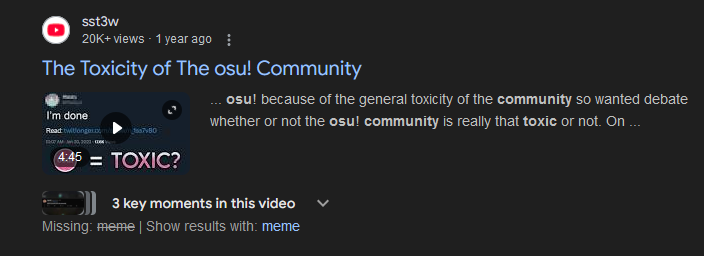

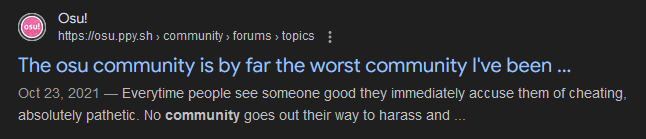

## Dataset

Il dataset e' composto da messaggi che vengono inviati realtime all'interno della chat #general di osu utilizzando la loro API
    (NB: Per poter utilizzare l'API di osu! bisogna registrare un osu! account che permette di ottenere una chiave API per l'accesso all'IRC)

## label del sentiment analysis

tramite textblob, performiamo  il sentiment analysis praticamente in questa maniera su `./spark/sentiment_analysis.py`

In [ ]:
def analyze_sentiment(message):
    blob = TextBlob(message)
    return blob.sentiment.polarity

tramite questa funzione, otterremo un valore floating dove poi su kibana tramite la funzione di dashboard andremo a creare vari intervalli per definire il sentiment del messaggio

Dove:
- -1.0 < x < -0.5 = toxic
- -0.5 < x < 0.0 = not nice
- 0.0 = x = 0.0 = neutral/meaningless
- 0.0 < x < 0.5 = somewhat nice
- 0.5 < x < 1.0 = nice

# Data Pipeline overview

![alt text](<data_pipelineOverview.png>)


# Data ingestion code

In [ ]:
import irc.client
import json
from datetime import datetime
import os
import logging
import signal
import sys
from typing import Optional
import time
import requests
from dotenv import load_dotenv

class IRCClient:
    def __init__(self):
        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )

        # Load environment variables from .env file
        load_dotenv()

        self.irc_config = {
            'server': "irc.ppy.sh",
            'port': 6667,
            'username': os.getenv("IRC_USERNAME"),
            'password': os.getenv("IRC_PASSWORD"),
            'channel': "#osu"
        }

        self.logstash_url = "http://logstash:5044"

        self.client = irc.client.Reactor()
        self.connection: Optional[irc.client.ServerConnection] = None
        self.running = True

    def on_message(self, connection, event):
        try:
            username = event.source.split("!")[0]
            message = event.arguments[0]
            timestamp = datetime.utcnow().isoformat()

            payload = {
                "username": username,
                "message": message,
                "timestamp": timestamp,
                "channel": self.irc_config['channel']
            }

            response = requests.post(self.logstash_url, json=payload)
            response.raise_for_status()

            logging.info(f"Message sent to Logstash: {username}: {message}")

        except Exception as e:
            logging.error(f"Error processing message: {e}")

    def on_connect(self, connection, event):
        logging.info(f"Connected to {self.irc_config['server']}")
        connection.join(self.irc_config['channel'])

    def on_disconnect(self, connection, event):
        logging.warning("Disconnected from server")
        if self.running:
            self.reconnect()

    def reconnect(self, max_attempts=5):
        attempts = 0
        while attempts < max_attempts and self.running:
            try:
                logging.info(f"Attempting to reconnect (attempt {attempts + 1})")
                self.connect()
                return True
            except Exception as e:
                logging.error(f"Reconnection failed: {e}")
                attempts += 1
                time.sleep(5)
        return False

    def connect(self):
        self.connection = self.client.server().connect(
            self.irc_config['server'],
            self.irc_config['port'],
            self.irc_config['username'],
            password=self.irc_config['password']
        )
        self.connection.add_global_handler("welcome", self.on_connect)
        self.connection.add_global_handler("pubmsg", self.on_message)
        self.connection.add_global_handler("disconnect", self.on_disconnect)

    def signal_handler(self, signum, frame):
        logging.info("Shutdown signal received")
        self.running = False
        if self.connection:
            self.connection.disconnect("Bot shutting down")
        sys.exit(0)

    def run(self):
        signal.signal(signal.SIGINT, self.signal_handler)
        signal.signal(signal.SIGTERM, self.signal_handler)

        try:
            self.connect()
            while self.running:
                self.client.process_once(timeout=0.2)
        except Exception as e:
            logging.error(f"Fatal error: {e}")
            self.running = False


L'interfacciamento con osu! api sarà svolto da uno script in python che fa uso della libreria irc il cui compito sarà quello di fetchare i post in streaming dal canale #osu (la chat generale si intende) e inoltrarli direttamente a logstash mediante interfaccia HTTP.
per poter utilizzare il codice bisogna installare le seguenti librerie:

In [ ]:
pip install python-dotenv requests irc

## logstash configuration

```conf
input {
  http {
    port => 5044
  }
}
```

definiamo la porta https che permette a logstash di ricevere i dati in ingresso.

definiamo la porta 5044 in questo caso, dove logstash ascoltera' tutti i messaggi inviati dallo script in python

```conf
output {
  kafka {
    bootstrap_servers => "kafka:9092"
    topic_id => "irc-messages"
    codec => json {
      target => "json_payload"
    }
  }
  stdout { codec => rubydebug }
}
```
questa configurazione invece e' l'output section che permette di inviare messaggi a kafka definendo un topic chiamato `irc-messages` e un codec json per il parsing dei messaggi in ingresso.

stdout e' un output plugin che permette di visualizzare i messaggi in maniera umana.

## Configurazione di kafka in docker

In seguito troveremo la configurazione di kafka all'interno di `docker-compose.yml` dove definiamo zookeeper che e' una dependency di kafka (senza di quello non riusciremmo nemmeno ad accendere kafka), kafka per l'appunto e kafka-init che e' un container che permette di creare i topic all'interno di kafka.


```dockerfile
zookeeper:
    image: bitnami/zookeeper:3.8
    environment:
      - ALLOW_ANONYMOUS_LOGIN=yes
      - ZOO_DATA_DIR=/bitnami/zookeeper
      - ZOO_LOG_DIR=/bitnami/zookeeper/logs
      - ZOO_TICK_TIME=2000
      - ZOO_INIT_LIMIT=10
      - ZOO_SYNC_LIMIT=5
    ports:
      - "2181:2181"
    volumes:
      - zookeeper_data:/bitnami/zookeeper
    networks:
      - app-network

  kafka:
    image: bitnami/kafka:3.5
    environment:
      - KAFKA_BROKER_ID=1
      - KAFKA_ZOOKEEPER_CONNECT=zookeeper:2181
      - KAFKA_LISTENERS=PLAINTEXT://:9092
      - KAFKA_ADVERTISED_LISTENERS=PLAINTEXT://kafka:9092
      - KAFKA_CREATE_TOPICS=irc-messages:1:1,irc-messages-sentiment:1:1
      - ALLOW_PLAINTEXT_LISTENER=yes
    ports:
      - "9092:9092"
    depends_on:
      - zookeeper
    volumes:
      - kafka_data:/bitnami/kafka
    networks:
      - app-network

  kafka-init:
    image: bitnami/kafka:3.5
    depends_on:
      - kafka
    entrypoint: /bin/bash
    command: -c "sleep 10 && \
      kafka-topics.sh --create --topic irc-messages --partitions 1 --replication-factor 1 --bootstrap-server kafka:9092 && \
      kafka-topics.sh --create --topic irc-messages-sentiment --partitions 1 --replication-factor 1 --bootstrap-server kafka:9092"
    networks:
      - app-network
```

### vari problemi di percorso

- inizialmente kafka non si voleva accendere perche' zookeeper si accendeva dopo di kafka, e dato che kafka dipende da zookeeper, inizialmente ho avuto problemi nel inizializzare la pipeline, inoltre avevo un problema con spark dove non riuscivo a collegare i vari topic tra di loro, cosi' ho creato un container che si chiama kafka-init, che inizialmente aspetta 10 secondi e poi accende kafka e crea i vari topic di cui avevo bisogno

### Configurazione di spark in docker

```dockerfile
spark-master:
  image: bitnami/spark:3.4.1
  environment:
    - SPARK_MODE=master
    - SPARK_RPC_AUTHENTICATION_ENABLED=no
    - SPARK_RPC_ENCRYPTION_ENABLED=no
    - SPARK_LOCAL_STORAGE_ENCRYPTION_ENABLED=no
    - SPARK_SSL_ENABLED=no
  ports:
    - "7077:7077"
    - "8080:8080"
  networks:
    - app-network
```

ho configurato spark in modalita' master, in modo tale che possa accedere alla dashboard di spark e vedere i vari job che vengono eseguiti e ne ho disabilitato le varie opzioni di sicurezza per semplificarne la configurazione.

Inoltre, ho configurato la porta 7077 per spark-worker e 8080 per la dashboard di spark. che collega il servizio all'app-network.

```dockerfile
spark-worker:
  build:
    context: ./spark
    dockerfile: worker.Dockerfile
  environment:
    - SPARK_MODE=worker
    - SPARK_MASTER_URL=spark://spark-master:7077
    - SPARK_WORKER_MEMORY=1G
    - SPARK_WORKER_CORES=1
  depends_on:
    - spark-master
  networks:
    - app-network
```

spark worker non fa altro che utilizzre l'immagine docker `./spark/worker.Dockerfile` che contiene tutte le librerie necessarie per eseguire il sentiment analysis sui messaggi.

```dockerfile
spark-submit:
  build:
    context: ./spark
    dockerfile: Dockerfile
  environment:
    - SPARK_MASTER_URL=spark://spark-master:7077
    - ELASTICSEARCH_HOST=elasticsearch
    - ELASTICSEARCH_PORT=9200
  depends_on:
    - spark-worker
    - kafka
    - elasticsearch
  networks:
    - app-network
```

spark submit invece e' il servizio che permette di inviare le informazioni a spark-worker, ma allo stesso tempo riceve i risultati da quest'ultima inviandoli a elastic search.


### vari problemi di percorso

Non riuscivo a far funzionare spark per via di vari problemi:

- spark submit non ascoltava nella porta corretta, quindi il loro funzionamento era compromesso, cosi' ho utilizato la variabile d'ambiente `SPARK_MASTER_URL` per definire l'URL
- spark-worker aveva bisogno delle dependencies per performare il sentiment analysis, nonostante fossero gia' settate all'interno di `./spark/Dockerfile` percio' ho creato un dockerfile apposito per spark-worker

## Configurazione di elasticsearch in docker

```dockerfile
elasticsearch:
    image: docker.elastic.co/elasticsearch/elasticsearch:7.17.5
    environment:
      - discovery.type=single-node
      - ES_JAVA_OPTS=-Xms512m -Xmx512m
    ports:
      - "9200:9200"
    networks:
      - app-network

  kibana:
    image: docker.elastic.co/kibana/kibana:7.17.5
    environment:
      ELASTICSEARCH_HOSTS: http://elasticsearch:9200
    ports:
      - "5601:5601"
    depends_on:
      - elasticsearch
    networks:
      - app-network
```

qui semplicemente definiamo elasticsearch e kibana all'interno di docker-compose.yml, dove elasticsearch e' il database che contiene i dati e kibana e' il servizio che permette di visualizzare i dati in maniera grafica, ho creato una dashboard per kibana che ho esportato in `./Kibana/dashboard.ndjson`

in questo modo, possiamo visualizzare i dati in maniera grafica e capire meglio il sentiment dei messaggi.

ho fatto le seguenti visualizzazioni:

- sentiment distribution in a heatmap
- count of sentiment-score in a graph
- cumulatime sum of user messages
- top 10 keyword used
- top 100 most active chatters
- unique count of messages and cumulative count of sentiment analysis visualized every 10 minutes

![image](https://cdn.discordapp.com/attachments/759863391107678238/1316910704539996200/image.png?ex=675cc42a&is=675b72aa&hm=509b3d789c01b3176aba351f7286ea5a2097c9077efc765292664d543cd631cf&)
